# 代码来源：https://blog.csdn.net/qq_42818403/article/details/122907583

In [21]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

print(sys.executable)

D:\anaconda\python.exe
D:\anaconda\python.exe


In [22]:
#周期性边界条件
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi/2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


In [23]:
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    
    f_u1 = u1_t + v1_xx + 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * v1 - 2*v1*(v2 ** 2 - u2 ** 2) - 4*v2*u1*u2
    f_v1 = v1_t - u1_xx - 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * u1 - 2*u1*(v2 ** 2 - u2 ** 2) + 4*v1*v2*u2
    
    f_u2 = u2_t + v2_xx + 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * v2 - 2*v2*(v1 ** 2 - u1 ** 2) - 4*v1*u2*u1
    f_v2 = v2_t - u2_xx - 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * u2 - 2*u2*(v1 ** 2 - u1 ** 2) + 4*v2*v1*u1

    return [f_u1, f_v1,f_u2,f_v2]


In [24]:
# 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)

# 初始条件
def init_cond_u1(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])
def init_cond_u2(x):
    "2 csch(x)"
    return 2 / np.sinh(x[:, 0:1])

def init_cond_v(x):
    return 0


ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=3)


In [25]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 4 + [4], "tanh", "Glorot normal")

model = dde.Model(data, net)


Adam 优化

In [26]:

# 强烈建议使用 GPU 加速系统.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=10000, display_every=100)


Compiling model...
Building feed-forward neural network...
'build' took 0.064782 s



C:\Users\86183\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.882667 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [5.34e-03, 1.71e-01, 1.97e-01, 3.84e-03, 3.56e-01, 4.94e-04, 2.94e-02, 1.35e-04, 1.42e-02, 5.92e-06, 1.63e+00, 6.47e-05, 9.13e-01, 1.10e-02, 5.95e+02, 2.04e-01]    [5.34e-03, 1.71e-01, 1.97e-01, 3.84e-03, 3.56e-01, 4.94e-04, 2.94e-02, 1.35e-04, 1.42e-02, 5.92e-06, 1.63e+00, 6.47e-05, 9.13e-01, 1.10e-02, 5.95e+02, 2.04e-01]    []  
100       [4.26e-02, 5.36e-02, 2.35e-01, 1.55e+00, 2.02e-04, 7.44e-05, 1.17e-04, 2.62e-05, 7.06e-04, 1.16e-04, 6.74e-05, 1.32e-03, 6.10e-01, 2.52e-03, 5.85e+02, 5.14e-03]    [4.26e-02, 5.36e-02, 2.35e-01, 1.55e+00, 2.02e-04, 7.44e-05, 

2300      [1.26e-01, 9.86e-02, 1.22e+00, 1.22e+00, 8.75e-04, 1.15e-03, 4.50e-04, 8.68e-04, 9.87e-03, 8.42e-03, 5.87e-03, 9.67e-03, 5.78e-01, 1.12e-03, 5.53e+02, 7.13e-02]    [1.26e-01, 9.86e-02, 1.22e+00, 1.22e+00, 8.75e-04, 1.15e-03, 4.50e-04, 8.68e-04, 9.87e-03, 8.42e-03, 5.87e-03, 9.67e-03, 5.78e-01, 1.12e-03, 5.53e+02, 7.13e-02]    []  
2400      [1.12e-01, 1.10e-01, 1.17e+00, 1.01e+00, 7.65e-04, 1.11e-03, 9.82e-04, 1.26e-03, 9.63e-03, 7.02e-03, 3.25e-03, 1.08e-02, 5.75e-01, 1.32e-03, 5.48e+02, 9.41e-02]    [1.12e-01, 1.10e-01, 1.17e+00, 1.01e+00, 7.65e-04, 1.11e-03, 9.82e-04, 1.26e-03, 9.63e-03, 7.02e-03, 3.25e-03, 1.08e-02, 5.75e-01, 1.32e-03, 5.48e+02, 9.41e-02]    []  
2500      [1.24e-01, 9.34e-02, 1.02e+00, 9.09e-01, 5.31e-04, 1.02e-03, 2.16e-03, 1.33e-03, 8.81e-03, 5.39e-03, 2.82e-03, 1.06e-02, 5.73e-01, 1.52e-03, 5.44e+02, 9.56e-02]    [1.24e-01, 9.34e-02, 1.02e+00, 9.09e-01, 5.31e-04, 1.02e-03, 2.16e-03, 1.33e-03, 8.81e-03, 5.39e-03, 2.82e-03, 1.06e-02, 5.73e-01, 1.52e-03,

4700      [1.49e-01, 1.08e-01, 9.72e-01, 2.17e+01, 4.07e-03, 4.70e-04, 5.96e-04, 4.68e-04, 1.57e-02, 3.88e-03, 4.85e-03, 4.31e-03, 4.50e-01, 1.16e-03, 5.14e+02, 8.82e-02]    [1.49e-01, 1.08e-01, 9.72e-01, 2.17e+01, 4.07e-03, 4.70e-04, 5.96e-04, 4.68e-04, 1.57e-02, 3.88e-03, 4.85e-03, 4.31e-03, 4.50e-01, 1.16e-03, 5.14e+02, 8.82e-02]    []  
4800      [8.38e-01, 3.78e-01, 3.16e+00, 2.03e+01, 3.97e-03, 3.18e-04, 2.86e-02, 9.23e-04, 1.91e-02, 4.24e-03, 3.15e-03, 7.29e-03, 4.47e-01, 1.33e-02, 5.15e+02, 5.81e-02]    [8.38e-01, 3.78e-01, 3.16e+00, 2.03e+01, 3.97e-03, 3.18e-04, 2.86e-02, 9.23e-04, 1.91e-02, 4.24e-03, 3.15e-03, 7.29e-03, 4.47e-01, 1.33e-02, 5.15e+02, 5.81e-02]    []  
4900      [1.53e-01, 1.07e-01, 7.73e-01, 7.43e-01, 4.85e-04, 3.91e-04, 1.91e-03, 4.15e-04, 4.33e-02, 4.63e-03, 8.91e-03, 6.25e-03, 4.82e-01, 1.13e-03, 5.20e+02, 8.12e-02]    [1.53e-01, 1.07e-01, 7.73e-01, 7.43e-01, 4.85e-04, 3.91e-04, 1.91e-03, 4.15e-04, 4.33e-02, 4.63e-03, 8.91e-03, 6.25e-03, 4.82e-01, 1.13e-03,

7100      [1.26e-01, 7.79e-02, 6.44e-01, 6.36e-01, 2.19e-03, 8.08e-04, 3.59e-04, 4.49e-04, 2.11e-02, 4.83e-03, 4.53e-03, 2.98e-03, 5.13e-01, 6.89e-04, 5.05e+02, 9.85e-02]    [1.26e-01, 7.79e-02, 6.44e-01, 6.36e-01, 2.19e-03, 8.08e-04, 3.59e-04, 4.49e-04, 2.11e-02, 4.83e-03, 4.53e-03, 2.98e-03, 5.13e-01, 6.89e-04, 5.05e+02, 9.85e-02]    []  
7200      [9.03e-02, 6.65e-02, 6.15e-01, 9.63e-01, 1.77e-03, 6.88e-04, 6.26e-04, 2.98e-04, 1.82e-02, 3.46e-03, 2.68e-03, 2.75e-03, 5.07e-01, 5.91e-04, 5.04e+02, 9.74e-02]    [9.03e-02, 6.65e-02, 6.15e-01, 9.63e-01, 1.77e-03, 6.88e-04, 6.26e-04, 2.98e-04, 1.82e-02, 3.46e-03, 2.68e-03, 2.75e-03, 5.07e-01, 5.91e-04, 5.04e+02, 9.74e-02]    []  
7300      [1.04e-01, 7.38e-02, 1.66e+00, 2.05e+00, 1.98e-03, 6.38e-04, 6.16e-04, 3.02e-04, 1.76e-02, 3.29e-03, 1.65e-03, 2.98e-03, 5.02e-01, 5.63e-04, 5.03e+02, 7.74e-02]    [1.04e-01, 7.38e-02, 1.66e+00, 2.05e+00, 1.98e-03, 6.38e-04, 6.16e-04, 3.02e-04, 1.76e-02, 3.29e-03, 1.65e-03, 2.98e-03, 5.02e-01, 5.63e-04,

9500      [7.11e-02, 6.14e-02, 1.18e+00, 1.37e+00, 1.07e-03, 7.73e-04, 3.03e-04, 1.33e-03, 2.41e-02, 9.38e-03, 2.44e-03, 5.37e-03, 5.92e-01, 1.96e-04, 5.66e+02, 3.20e-02]    [7.11e-02, 6.14e-02, 1.18e+00, 1.37e+00, 1.07e-03, 7.73e-04, 3.03e-04, 1.33e-03, 2.41e-02, 9.38e-03, 2.44e-03, 5.37e-03, 5.92e-01, 1.96e-04, 5.66e+02, 3.20e-02]    []  
9600      [7.09e-02, 5.77e-02, 1.20e+00, 1.32e+00, 1.21e-03, 1.01e-03, 3.44e-04, 1.01e-03, 2.23e-02, 1.07e-02, 2.52e-03, 5.82e-03, 5.89e-01, 3.25e-04, 5.65e+02, 3.23e-02]    [7.09e-02, 5.77e-02, 1.20e+00, 1.32e+00, 1.21e-03, 1.01e-03, 3.44e-04, 1.01e-03, 2.23e-02, 1.07e-02, 2.52e-03, 5.82e-03, 5.89e-01, 3.25e-04, 5.65e+02, 3.23e-02]    []  
9700      [7.33e-02, 5.52e-02, 1.21e+00, 1.28e+00, 1.45e-03, 1.20e-03, 6.15e-04, 6.57e-04, 2.08e-02, 1.14e-02, 2.97e-03, 5.60e-03, 5.85e-01, 5.41e-04, 5.64e+02, 3.14e-02]    [7.33e-02, 5.52e-02, 1.21e+00, 1.28e+00, 1.45e-03, 1.20e-03, 6.15e-04, 6.57e-04, 2.08e-02, 1.14e-02, 2.97e-03, 5.60e-03, 5.85e-01, 5.41e-04,

(<deepxde.model.LossHistory at 0x273f0109790>,
 <deepxde.model.TrainState at 0x273f03b3c10>)

L-BFGS 优化

Compiling model...
'compile' took 2.238758 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
10000     [7.38e-02, 5.54e-02, 1.22e+00, 1.13e+00, 1.62e-03, 1.41e-03, 1.21e-03, 1.48e-04, 1.58e-02, 1.09e-02, 3.76e-03, 4.51e-03, 5.89e-01, 1.14e-03, 5.61e+02, 2.41e-02]    [7.38e-02, 5.54e-02, 1.22e+00, 1.13e+00, 1.62e-03, 1.41e-03, 1.21e-03, 1.48e-04, 1.58e-02, 1.09e-02, 3.76e-03, 4.51e-03, 5.89e-01, 1.14e-03, 5.61e+02, 2.41e-02]    []  
11000     [3.79e-01, 4.03e-01, 3.32e+00, 3.30e+00, 4.64e-03, 1.69e-03, 3.44e-03, 3.16e-04, 5.92e-03, 1.57e-02, 8.03e-03, 1.53e-02, 5.81e-01, 2.28e-03, 5.04e+02, 2.93e-01]                                                                        

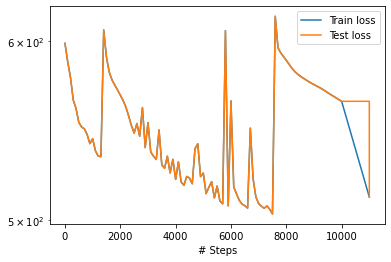

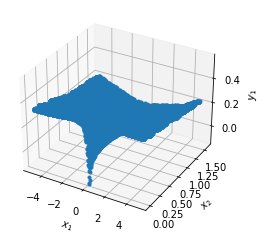

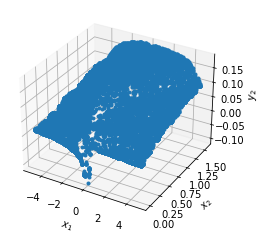

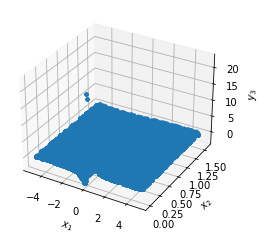

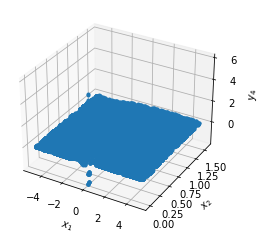

In [27]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=1000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

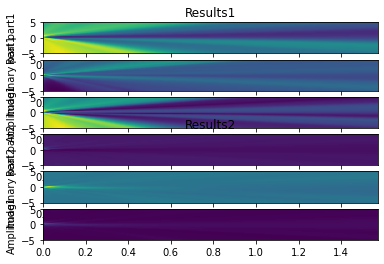

In [28]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(6)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[3].set_title("Results2")
ax[3].set_ylabel("Real part2")
ax[3].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[4].set_ylabel("Imaginary part2")
ax[4].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[5].set_ylabel("Amplitude1")
ax[5].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()


[30793 30780 30767 ...    50    52    53]


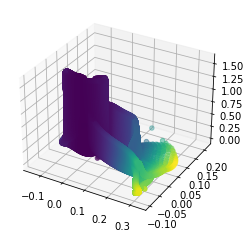

In [31]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(prediction[:, 0],prediction[:, 1],X_star[:,1],c=d[:]*2)



[2 2 2 ... 4 4 4]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


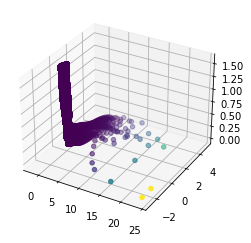

In [32]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(prediction[:, 2],prediction[:, 3],X_star[:,1],c=d[:]*2)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)